# Breast cancer data set

In [2]:
import pandas as pd
import numpy as np

breast_cancer_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/breast-cancer-wisconsin.csv.gz',
                                 sep='\t',
                                 compression='gzip')

breast_cancer_data = pd.concat([breast_cancer_data.loc[
            np.random.choice(breast_cancer_data.loc[breast_cancer_data['class'] == 0].index.values, 212)],
                                breast_cancer_data.loc[breast_cancer_data['class'] == 1]])

## Class frequencies

In [3]:
from collections import Counter

Counter(breast_cancer_data['class'].values)

Counter({0: 212, 1: 212})

## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [3]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                breast_cancer_data.drop('class', axis=1).values,
                breast_cancer_data.loc[:, 'class'].values, cv=10)

array([ 0.97727273,  0.88636364,  0.95238095,  0.97619048,  0.95238095,
        0.97619048,  0.97619048,  0.97619048,  1.        ,  0.97619048])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


''

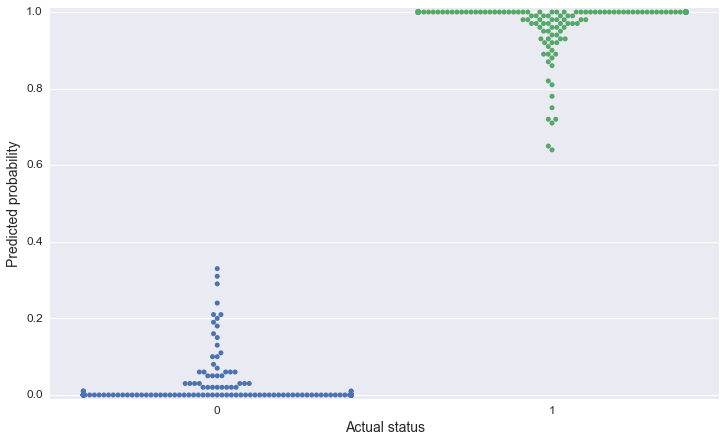

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

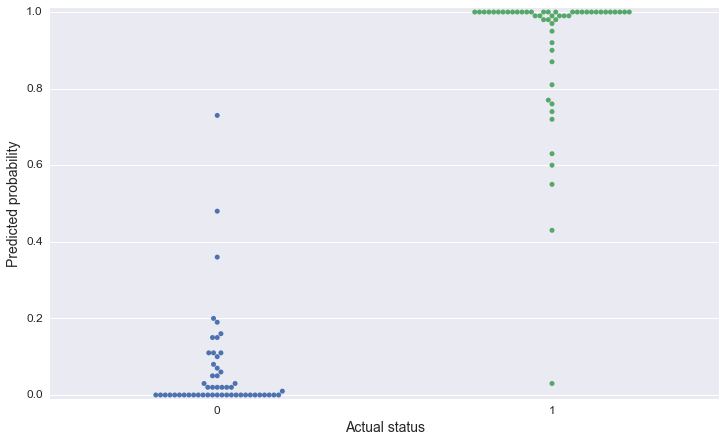

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

## Crowd machine

1. Run random forest with 15 or 20 different terminal node sizes, on the same training data, in each case getting the probability for each subject or instance;
2. Use the output from each as a new synthetic feature, which is then input to another (single) random random forest, also run in regression mode; In this case the probability estimates from each synthetic feature will be sort of continuous as they are probability estimates and not just zero or one things;
3. Generate some simple plots for the crowd;
4. Compare the crowd results to some individual random forest runs, using some two or three terminal node settings.

In [91]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

breast_cancer_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/breast-cancer-wisconsin.csv.gz',
                                 sep='\t',
                                 compression='gzip')

breast_cancer_data = pd.concat([breast_cancer_data.loc[
            np.random.choice(breast_cancer_data.loc[breast_cancer_data['class'] == 0].index.values, 212)],
                                breast_cancer_data.loc[breast_cancer_data['class'] == 1]])

shuffled_indices = breast_cancer_data.index.values
np.random.shuffle(shuffled_indices)
breast_cancer_data = breast_cancer_data.loc[shuffled_indices]

all_features = breast_cancer_data.drop('class', axis=1).values
all_classes = breast_cancer_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.21, 0.01)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.2f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

RF w/ mwfl=0.00 CV score: 0.972
RF w/ mwfl=0.01 CV score: 0.968
RF w/ mwfl=0.02 CV score: 0.966
RF w/ mwfl=0.03 CV score: 0.955
RF w/ mwfl=0.04 CV score: 0.949
RF w/ mwfl=0.05 CV score: 0.941
RF w/ mwfl=0.06 CV score: 0.940
RF w/ mwfl=0.07 CV score: 0.930
RF w/ mwfl=0.08 CV score: 0.934
RF w/ mwfl=0.09 CV score: 0.932
RF w/ mwfl=0.10 CV score: 0.924
RF w/ mwfl=0.11 CV score: 0.938
RF w/ mwfl=0.12 CV score: 0.930
RF w/ mwfl=0.13 CV score: 0.938
RF w/ mwfl=0.14 CV score: 0.934
RF w/ mwfl=0.15 CV score: 0.934
RF w/ mwfl=0.16 CV score: 0.924
RF w/ mwfl=0.17 CV score: 0.941
RF w/ mwfl=0.18 CV score: 0.924
RF w/ mwfl=0.19 CV score: 0.932
RF w/ mwfl=0.20 CV score: 0.938
Crowd machine CV score: 0.974


# Spambase data set

In [6]:
import pandas as pd

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

spambase_data = pd.concat([spambase_data.loc[
            np.random.choice(spambase_data.loc[spambase_data['class'] == 0].index.values, 1813)],
                                spambase_data.loc[spambase_data['class'] == 1]])

## Class frequencies

In [7]:
from collections import Counter

Counter(spambase_data['class'].values)

Counter({0: 1813, 1: 1813})

## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [8]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                spambase_data.drop('class', axis=1).values,
                spambase_data.loc[:, 'class'].values,
                cv=10)

array([ 0.95054945,  0.94230769,  0.93681319,  0.95856354,  0.96961326,
        0.97513812,  0.9640884 ,  0.96132597,  0.94198895,  0.91160221])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

''

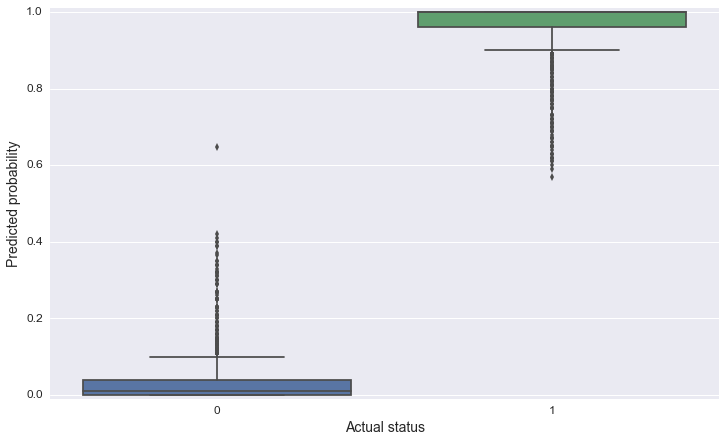

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

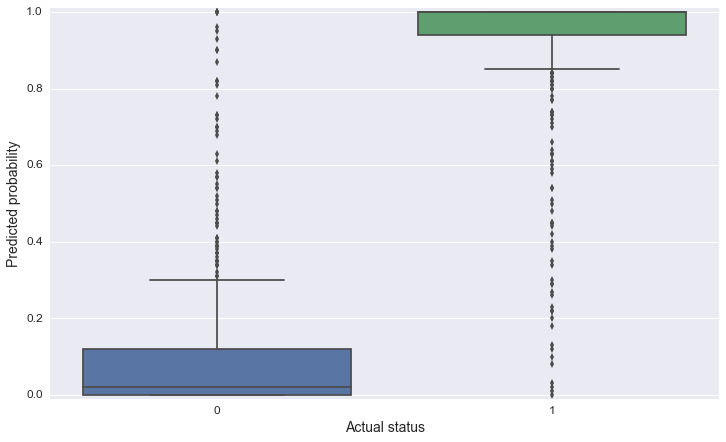

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

## Crowd machine

1. Run random forest with 15 or 20 different terminal node sizes, on the same training data, in each case getting the probability for each subject or instance;
2. Use the output from each as a new synthetic feature, which is then input to another (single) random random forest, also run in regression mode; In this case the probability estimates from each synthetic feature will be sort of continuous as they are probability estimates and not just zero or one things;
3. Generate some simple plots for the crowd;
4. Compare the crowd results to some individual random forest runs, using some two or three terminal node settings.

In [92]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

spambase_data = pd.concat([spambase_data.loc[
            np.random.choice(spambase_data.loc[spambase_data['class'] == 0].index.values, 1813)],
                                spambase_data.loc[spambase_data['class'] == 1]])

shuffled_indices = spambase_data.index.values
np.random.shuffle(shuffled_indices)
spambase_data = spambase_data.loc[shuffled_indices]

all_features = spambase_data.drop('class', axis=1).values
all_classes = spambase_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.21, 0.01)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.2f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

RF w/ mwfl=0.00 CV score: 0.967
RF w/ mwfl=0.01 CV score: 0.933
RF w/ mwfl=0.02 CV score: 0.923
RF w/ mwfl=0.03 CV score: 0.918
RF w/ mwfl=0.04 CV score: 0.911
RF w/ mwfl=0.05 CV score: 0.907
RF w/ mwfl=0.06 CV score: 0.904
RF w/ mwfl=0.07 CV score: 0.904
RF w/ mwfl=0.08 CV score: 0.898
RF w/ mwfl=0.09 CV score: 0.904
RF w/ mwfl=0.10 CV score: 0.901
RF w/ mwfl=0.11 CV score: 0.896
RF w/ mwfl=0.12 CV score: 0.895
RF w/ mwfl=0.13 CV score: 0.898
RF w/ mwfl=0.14 CV score: 0.891
RF w/ mwfl=0.15 CV score: 0.893
RF w/ mwfl=0.16 CV score: 0.887
RF w/ mwfl=0.17 CV score: 0.887
RF w/ mwfl=0.18 CV score: 0.889
RF w/ mwfl=0.19 CV score: 0.883
RF w/ mwfl=0.20 CV score: 0.875
Crowd machine CV score: 0.959
